In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from models.deepclean import DeepCleanAE, FFTDeepCleanAE
from signal_gen.generate_signal import build_empty_signal, gauss_sig
from signal_gen.colored_noise import add_noise_to_signal
import matplotlib.pyplot as plt
from models.base_dense import BaselineDense

In [36]:
import scipy.signal as scipy_signal

n = 1000
sr = 1000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3

def build_empty_signal(n, sr):
    t = np.arange(n) / sr
    x = np.zeros(n)
    return x, t

def gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    signal_length = len(x)
    
    for _ in range(num_pulses):
        std = np.random.uniform(std_min, std_max)
        amp = np.random.uniform(amp_min, amp_max)
        
        window_length = int(2 * std_length * std)  # Ensure the window length is odd
        if window_length % 2 == 1: window_length -= 1
                
        window = scipy_signal.windows.gaussian(window_length, std=std)
        window = amp*window
        
        
        pos = np.random.randint(window_length, signal_length-window_length//2)
        
        start = pos - (window_length // 2) 
        end = pos + (window_length // 2 )
        
        
        window_segment = window[:end - start]  # Adjust the length of the window segment
        x[start:end] += window_segment

        '''
        plt.figure(figsize=(12, 6))
        plt.plot(t, x)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Signal with Gaussian Pulses')
        plt.grid(True)
        plt.show()
        '''

    return x, amp

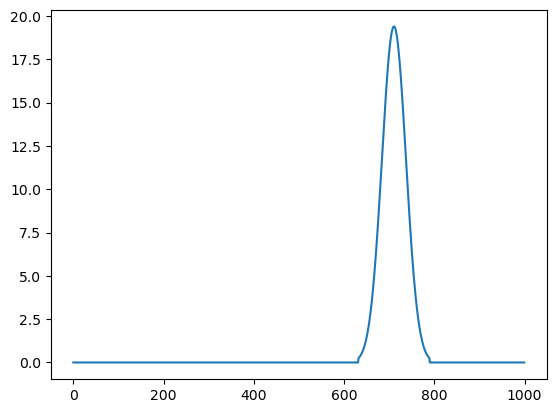

In [4]:
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)

# Generate A Gaussian Pulse

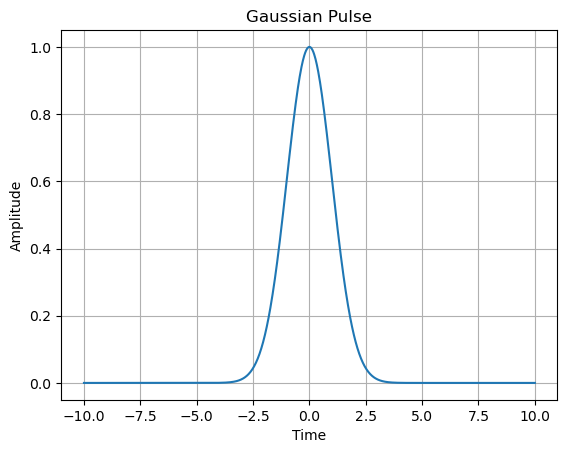

In [5]:
def generate_gaussian_pulse(N):
    # Parameters for the Gaussian pulse
    t = np.linspace(-10, 10, N)  # Time axis
    A = 1.0  # Amplitude
    sigma = 1.0  # Standard deviation (controls the width of the pulse)
    center = 0.0  # Center of the pulse

    # Gaussian pulse equation
    gaussian_pulse = A * np.exp(-(t - center)**2 / (2 * sigma**2))
    return gaussian_pulse

t = np.linspace(-10, 10, 1000)
sample_gaussian_pulse = generate_gaussian_pulse(1000)
# Plot the Gaussian pulse
plt.plot(t, sample_gaussian_pulse)
plt.title('Gaussian Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Generate Colored Noise

In [6]:
def generate_white_noise(N):
    """Generate white noise."""
    return np.random.normal(size=N)

def generate_colored_noise(N, color='white'):
    """Generate colored noise."""
    # Generate white noise
    white_noise = generate_white_noise(N)
    
    # FFT to go to the frequency domain
    f_noise = np.fft.rfft(white_noise)
    
    # Generate the frequency index
    f = np.fft.rfftfreq(N)
    
    # Apply frequency-dependent scaling
    if color == 'pink':
        f_noise = f_noise / (f + 1e-8)  # Avoid division by zero
    elif color == 'brown':
        f_noise = f_noise / (f**2 + 1e-8)
    elif color == 'blue':
        f_noise = f_noise * f
    elif color == 'violet':
        f_noise = f_noise * (f**2)
    
    # Inverse FFT to return to time domain
    colored_noise = np.fft.irfft(f_noise, n=N)
    
    return colored_noise

def generate_noise_freq(N, A, duration, sample_rate, freqs = []):
    
    t = np.linspace(0, duration, int(sample_rate*duration))  # Time axis
    
    noise = np.zeros_like(t)
    for freq in freqs:
        noise += A*np.sin(2*np.pi*freq*t)
    return noise


# # Parameters
# N = 1000  # Number of samples
# color_type = 'brown'  # Choose from 'white', 'pink', 'brown', 'blue', 'violet'

# # Generate colored noise
# colored_noise = generate_colored_noise(N, color=color_type)
# # colored_noise = generate_white_noise(N)

# # Plot the noise
# plt.plot(colored_noise)
# plt.title(f'{color_type.capitalize()} Noise')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.show()

# sample_gaussian_pulse = generate_gaussian_pulse(1000)
# noise = generate_noise_freq(1000, 0.1, [0.1, 0.2])
# plt.plot(noise)
# plt.show()
# plt.plot(sample_gaussian_pulse+noise)


# Generate Dataset with Noise

In [11]:
import random
dataset_size = 1000
sr = 10000
X = []
Y = []
duration = 2
sample_rate = 5000
N = duration * sample_rate
noise_amplitude = 0.3
for i in range(dataset_size):
    freq = random.sample([1,],1)
    x, t = build_empty_signal(N, sr)
    x, amp = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    noise = generate_noise_freq(N, noise_amplitude, duration, sample_rate, freq)
    X.append(x+noise)
    Y.append(noise)
        

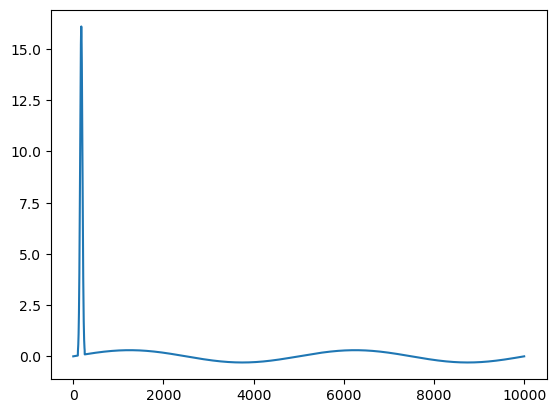

In [12]:
plt.plot(X[0])

100.78035418327835


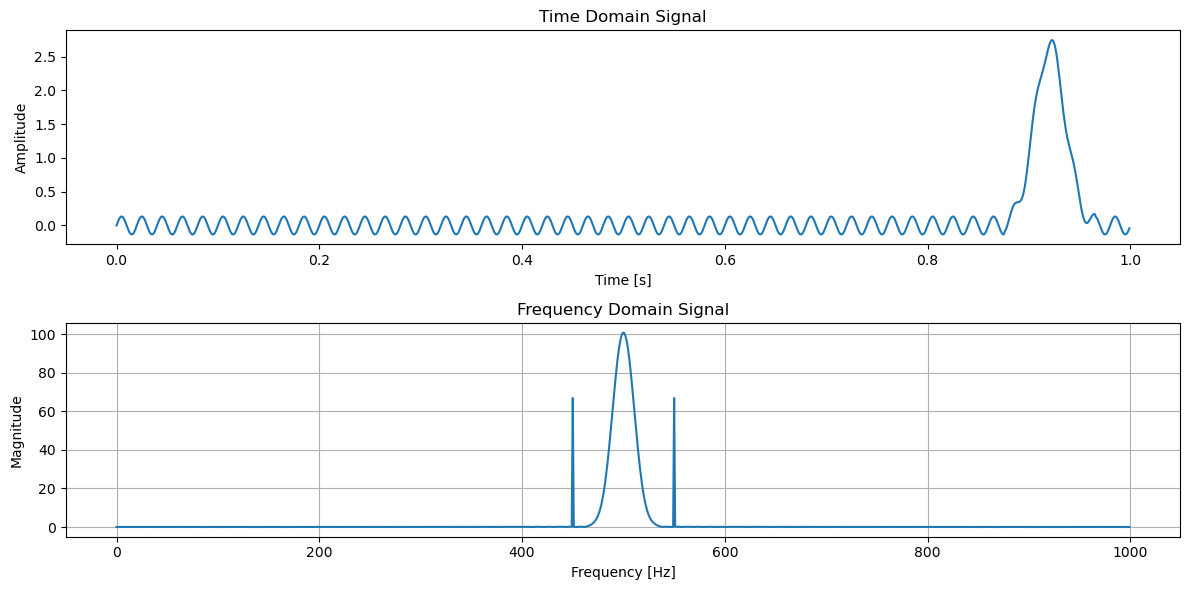

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a sample signal (sine wave)
sampling_rate = 1000  # Sampling rate in Hz
duration = 1.0        # Duration in seconds
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  # Time array

x, t = build_empty_signal( int(sampling_rate * duration), sampling_rate)
x, amp = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)

# Create a signal: a sum of two sine waves (frequencies: 50 Hz and 120 Hz)
freq1 = 50  # Frequency of the first sine wave in Hz
freq2 = 120 # Frequency of the second sine wave in Hz
signal = 0.05*amp*np.sin(2 * np.pi * freq1 * t) + x

# Step 2: Perform the Fourier Transform
# Compute the 1D Fourier Transform using numpy.fft.fft
fft_values = np.fft.fft(signal)

# Step 3: Compute the corresponding frequencies
frequencies = np.fft.fftfreq(len(fft_values), 1 / sampling_rate)
print(max(np.fft.fftshift(np.abs(fft_values))))
# Step 4: Plot the original signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Step 5: Plot the magnitude of the Fourier Transform
# Use np.abs() to get the magnitude and focus on positive frequencies
plt.subplot(2, 1, 2)
plt.plot(np.fft.fftshift(np.abs(fft_values)))
# plt.stem(frequencies[:len(frequencies)//2], np.abs(fft_values)[:len(frequencies)//2], use_line_collection=True)
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

In [86]:
import random
dataset_size = 1000
sr = 10000
X = []
Y = []
duration = 2
sample_rate = 5000
N = duration * sample_rate
noise_amplitude = 0.3
for i in range(dataset_size):
    freq = random.sample([1,],1)
    x, t = build_empty_signal(N, sr)
    x, amp = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    # noise = generate_noise_freq(N, noise_amplitude, duration, sample_rate, freq)
    freq1 = 50  # Frequency of the first sine wave in Hz
    noise = amp*0.05*np.sin(2 * np.pi * freq1 * t)
    mean_signal = np.mean(signal)
    mean_noise = np.mean(noise)
    signal = noise + x
    fft_values_noise = (np.fft.fft(noise) - mean_signal)/N
    fft_values_signal = (np.fft.fft(signal) - mean_noise)/N
    x = np.fft.fftshift(np.abs(fft_values_signal))
    y = np.fft.fftshift(np.abs(fft_values_noise))
    X.append(x)
    Y.append(y)
        

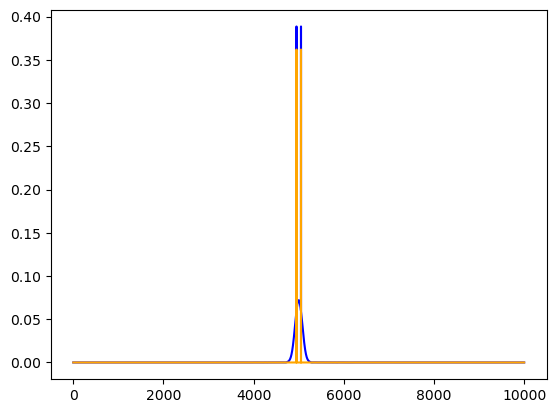

In [87]:
i = 4
plt.plot(X[i], color="blue")
plt.plot(Y[i], color="orange")


In [89]:
X = torch.tensor(X).unsqueeze(dim=1).to(torch.float32)
Y = torch.tensor(Y).to(torch.float32)
print(X.shape)
print(Y.shape)

torch.Size([1000, 1, 10000])
torch.Size([1000, 10000])


# Training Setup

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# dataset generation
batch_size = 16
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
in_channels = 1
model = FFTDeepCleanAE(in_channels)
# model.load_state_dict(torch.load("deepclean_model.pth"))

data_for_viz = {}

# Loss function and optimizer
criterion = nn.L1Loss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        if batch == 0:
            data_for_viz[epoch] = {} # data_for_viz.get(epoch, {})
            data_for_viz[epoch]["input"] = inputs.detach().numpy()
            data_for_viz[epoch]["input_encoding"] = model.encodings["input_conv"]
            for name, _, in list(model.downsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"downsample_{name}"] = model.encodings[f"downsample_{name}"]
            for name, _, in list(model.upsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"upsample_{name}"] = model.encodings[f"upsample_{name}"]
            data_for_viz[epoch]["output_conv"] = model.encodings["output_conv"]
        batch += 1   
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.10f}')

Epoch [1/100], Loss: 0.0161402656
Epoch [2/100], Loss: 0.0064058110
Epoch [3/100], Loss: 0.0074362170
Epoch [4/100], Loss: 0.0050497533
Epoch [5/100], Loss: 0.0061217849
Epoch [6/100], Loss: 0.0044872893
Epoch [7/100], Loss: 0.0059534813


KeyboardInterrupt: 

In [119]:
noise_freq = model(inputs)[0]

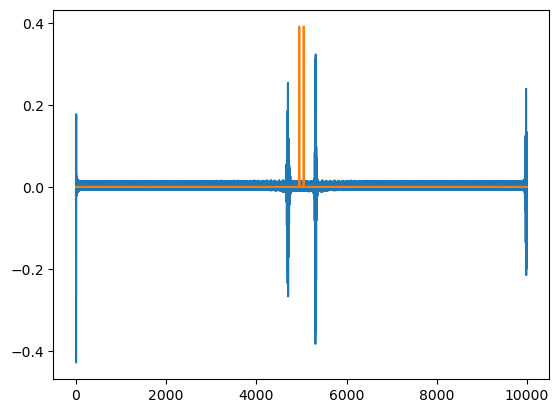

In [120]:
plt.plot(noise_freq.detach().numpy())
plt.plot(labels[0].detach().numpy()) 

In [116]:
print(np.argmax(np.abs(np.fft.ifft(noise_freq.detach().numpy()))))
print(np.argmax(labels[0].detach().numpy()))

4375
4950


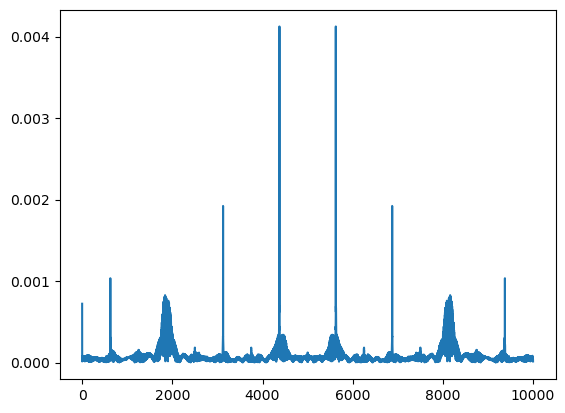

In [112]:
plt.plot(np.abs(np.fft.ifft(noise_freq.detach().numpy())))
